# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Importing libraries and loading datasets

In [5]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**Importing additional libraries**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

**Showing the first to rows of the datasets**

In [10]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [11]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [12]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


### Data accessing and cleansing

#### 1. Portfolio
Dataset overview: **portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

##### 1.1 Data Accessing

In [13]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [15]:
portfolio.shape

(10, 6)

In [17]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [18]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [21]:
set(portfolio['offer_type'].unique())

{'bogo', 'discount', 'informational'}

In [26]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

##### 1.2 Data Cleansing
* Splitting the 'channels' column into columns for each fo the channels
* Rename the column 'id' to 'offer_id'

In [27]:
portfolio_copy = portfolio.copy()

In [28]:
dummy = pd.get_dummies(portfolio_copy.channels.apply(pd.Series).stack()).sum(level=0)
portfolio_copy = pd.concat([portfolio_copy, dummy], axis=1)
portfolio_copy = portfolio_copy.drop(columns='channels')

In [29]:
portfolio_copy = portfolio_copy.rename(columns={'id':'offer_id'})

In [30]:
portfolio_copy

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


#### 2. Profile
Dataset overview: **profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


##### 2.1 Data Accessing

In [31]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [32]:
profile.shape

(17000, 5)

In [33]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [34]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [35]:
set(profile['gender'].unique())

{'F', 'M', None, 'O'}

##### 2.2 Data Cleansing

* Converting the column 'became_member_on' to a date format
* Renaming the column 'id' to 'customer_id' to clarify the meaning behind it

In [47]:
profile_copy = profile.copy()

In [48]:
profile_copy['became_member_on'] = pd.to_datetime(profile_copy['became_member_on'], format='%Y%m%d')

In [49]:
profile_copy = profile_copy.rename(columns={'id':'customer_id'})

In [50]:
profile_copy.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [62]:
profile_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   customer_id       17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


#### 3. Transcript
Dataset overview: **transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

##### 3.1 Data Accessing

In [63]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [64]:
transcript.shape

(306534, 4)

In [65]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [66]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [79]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [80]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

##### 3.2 Data cleansing

* Renaming the column 'person' to 'customer_id' to match the previous dataframe
* Convert the column 'event' into four different columns with dummy values
* Splitting the column 'value' into two columns

In [84]:
transcript_copy = transcript.copy()

In [85]:
transcript_copy = transcript_copy.rename(columns={'person':'customer_id'})

In [86]:
transcript_copy['event'] = transcript_copy['event'].str.replace(' ', '-')
transcript_copy['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [88]:
dummy = pd.get_dummies(transcript_copy['event'])
transcript_copy = pd.concat([transcript_copy, dummy], axis=1 )

In [90]:
transcript_copy

,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,0,0,0,1


In [91]:
transcript_copy['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript_copy.value]
transcript_copy['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript_copy.value]

In [95]:
transcript_copy.head(2)

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [93]:
transcript_copy = transcript_copy.drop(columns='value')

In [94]:
transcript_copy.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


#### Merging all three datasets into one big dataset

In [96]:
tran_prof = pd.merge(transcript_copy, profile_copy, on='customer_id')

In [98]:
tran_prof.head(3)

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.0


In [100]:
df = pd.merge(tran_prof, portfolio_copy, on='offer_id', how='left')
df.head(3)

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
offer_id = df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [105]:
offer_dict = dict([(value, key) for key, value in pd.Series(offer_id ).to_dict().items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [106]:
df['offer_id'] = df['offer_id'].map(offer_dict)
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,1,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,1,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
df['offer_id'] = df['offer_id'].replace(1, np.nan)
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
set(df['offer_id'].unique())

{0.0, nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}

In [110]:
event_ids = df['event'].unique()
event_ids

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'],
      dtype=object)

In [111]:
event_dict = pd.Series(event_ids).to_dict()
event_dict

{0: 'offer-received',
 1: 'offer-viewed',
 2: 'transaction',
 3: 'offer-completed'}

In [112]:
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{'offer-received': 0,
 'offer-viewed': 1,
 'transaction': 2,
 'offer-completed': 3}

In [114]:
df['event_id'] = df['event'].map(event_dict)
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [115]:
df.shape

(306534, 22)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   offer-completed   306534 non-null  uint8         
 4   offer-received    306534 non-null  uint8         
 5   offer-viewed      306534 non-null  uint8         
 6   transaction       306534 non-null  uint8         
 7   offer_id          167581 non-null  float64       
 8   amount            138953 non-null  float64       
 9   gender            272762 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            272762 non-null  float64       
 13  reward            167581 non-null  float64       
 14  diff

In [120]:
df.to_csv('data/data.csv', index=False)

In [1]:
data = pd.read_csv('data/data.csv')

In [22]:
data.head(3)

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


### Data exploration and visualization

In [2]:
data['age'].describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

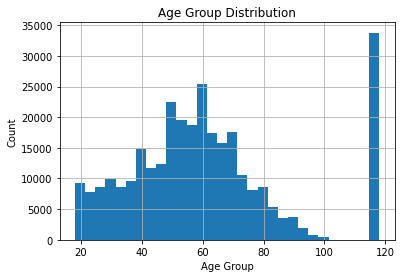

In [6]:
data['age'].hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

##### Detection
* The dataset contains a lot of outliers with age > 115. This doesn't make sense at all.

In [7]:
data['income'].describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

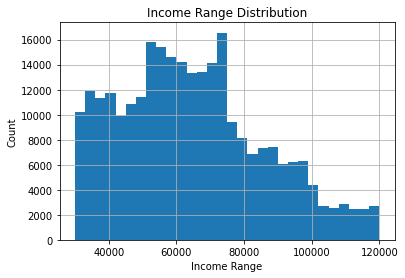

In [21]:
data['income'].hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

##### Detection
* The highest customer count with > 16,000 is in the income gorup between 70,000 and 75,000

In [16]:
data['gender'].value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [17]:
males  = data['gender'].value_counts()[0] / data.shape[0]*100
females = data['gender'].value_counts()[1] / data.shape[0]*100
others = data['gender'].value_counts()[2] / data.shape[0]*100

males, females, others

(50.79045065147749, 36.89672271265177, 1.2954517280301696)

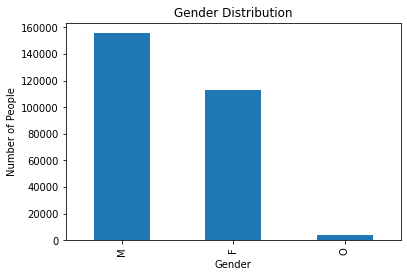

In [18]:
ax = data['gender'].value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

##### Detection
* The datasets contains more males than females or others

In [32]:
offer_received = data[data['offer-received'] == 1]['offer_type'].value_counts()
offer_viewed = data[data['offer-viewed'] == 1]['offer_type'].value_counts()
offer_completed = data[data['offer-completed'] == 1]['offer_type'].value_counts()

offer_received, offer_viewed, offer_completed 

(discount         30543
 bogo             30499
 informational    15235
 Name: offer_type, dtype: int64,
 bogo             25449
 discount         21445
 informational    10831
 Name: offer_type, dtype: int64,
 discount    17910
 bogo        15669
 Name: offer_type, dtype: int64)

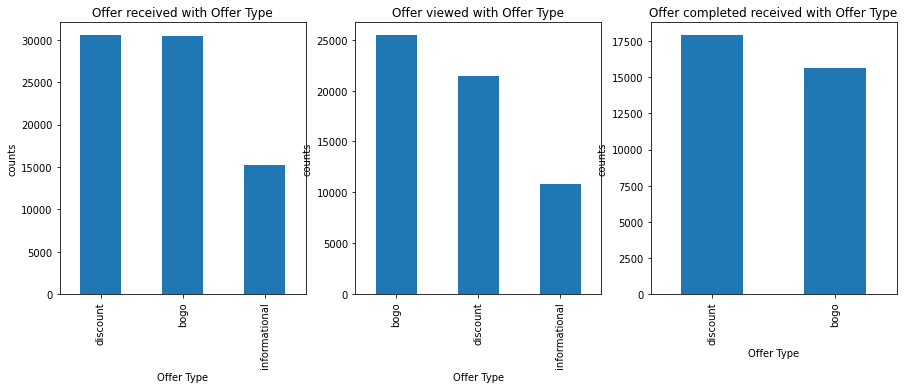

In [44]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1]['offer_type'].value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1]['offer_type'].value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1]['offer_type'].value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type');

In [41]:
BOGO_R = offer_received[1] 
BOGO_V = offer_viewed[0] 
BOGO_C = offer_completed[1] 

view_prop = BOGO_V/BOGO_R
com_prop = BOGO_C/BOGO_R
BOGO_R, BOGO_V, BOGO_C, round(view_prop * 100, 2), round(com_prop * 100, 2)

(30499, 25449, 15669, 83.44, 51.38)

In [42]:
DISCOUNT_R = offer_received[0] 
DISCOUNT_V = offer_viewed[1] 
DISCOUNT_C = offer_completed[0] 

view_prop = DISCOUNT_V/DISCOUNT_R
com_prop = DISCOUNT_C/DISCOUNT_R
DISCOUNT_R, DISCOUNT_V, DISCOUNT_C, round(view_prop * 100, 2), round(com_prop * 100, 2)

(30543, 21445, 17910, 70.21, 58.64)

##### Detection
* The most completed offers were for the offer type 'discount'
* The number of offers received were the highest for the discounts with 30,543, while bogo had 30,499 offers.
* The view_prop-variable above for 'discount' shows that ~59% of the received offers were actually completed, while ~70% of the received offers were viewed.
* The view_prop-variable above for 'bogo' shows that ~51% of the received offers were actually completed, while ~83% of the received offers were viewed.

In [43]:
offer_received = data[data['offer-received'] == 1]['offer_id'].value_counts()
offer_viewed = data[data['offer-viewed'] == 1]['offer_id'].value_counts()
offer_completed = data[data['offer-completed'] == 1]['offer_id'].value_counts()

offer_received, offer_viewed, offer_completed 

(0.0     7677
 5.0     7668
 3.0     7658
 10.0    7646
 7.0     7632
 2.0     7618
 6.0     7617
 8.0     7597
 9.0     7593
 4.0     7571
 Name: offer_id, dtype: int64,
 10.0    7337
 8.0     7327
 9.0     7298
 4.0     7264
 3.0     6716
 2.0     6687
 0.0     4171
 6.0     4144
 7.0     4118
 5.0     2663
 Name: offer_id, dtype: int64,
 8.0     5317
 10.0    5156
 0.0     4354
 4.0     4296
 7.0     4017
 3.0     3688
 5.0     3420
 9.0     3331
 Name: offer_id, dtype: int64)

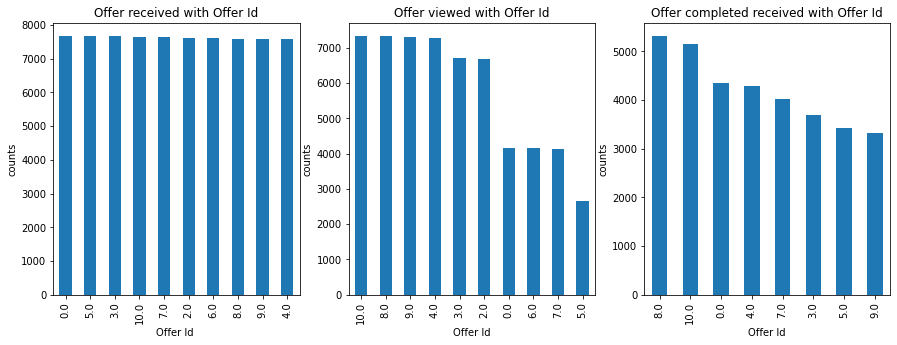

In [45]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1]['offer_id'].value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1]['offer_id'].value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1]['offer_id'].value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id');

##### Detection
* Every Offer Id received almost the same amount of offers.
* The viewed offers however differ a lot. Offer Id 10, 8, 9 and 4 are almost at the same level, the lowest viewed count is for the offer id 5
* The most completed offers however were for Offer Id 8, followed by 10 with a little difference. The numbers can be seen three steps above.

In [47]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count()

customer_id
0009655768c64bdeb2e877511632db8f    3
00116118485d4dfda04fdbaba9a87b5c    4
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    4
0020ccbbb6d84e358d3414a3ff76cffd    6
                                   ..
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    6
fff8957ea8b240a6b5e634b6ee8eafcf    2
fffad4f4828548d1b5583907f2e9906b    9
ffff82501cea40309d5fdd7edcca4a07    3
Name: offer-received, Length: 14992, dtype: int64

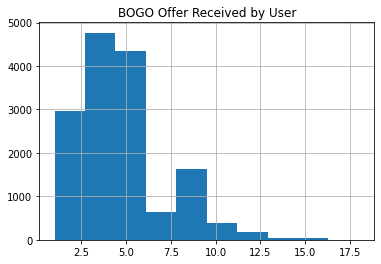

In [48]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count().hist();
plt.title('BOGO Offer Received by User');

##### Detection
* The BOGO offers were received by a lot of users

In [50]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count()

customer_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
                                   ..
ffecb1f8543f4bf7bade023de366d6bf    2
fff0f0aac6c547b9b263080f09a5586a    4
fff3ba4757bd42088c044ca26d73817a    3
fff8957ea8b240a6b5e634b6ee8eafcf    1
fffad4f4828548d1b5583907f2e9906b    2
Name: offer-viewed, Length: 10547, dtype: int64

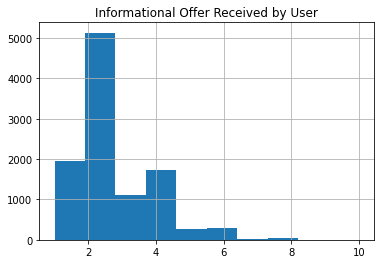

In [51]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count().hist();
plt.title('Informational Offer Received by User');

##### Detection
* There is a huge difference between the count of the views
* The highest ratio of viewed offers is between 2 and 3 offers

In [52]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count()

customer_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
                                    ..
fff29fb549084123bd046dbc5ceb4faa     3
fff3ba4757bd42088c044ca26d73817a     6
fff7576017104bcc8677a8d63322b5e1     6
fff8957ea8b240a6b5e634b6ee8eafcf     2
ffff82501cea40309d5fdd7edcca4a07    15
Name: offer-completed, Length: 14945, dtype: int64

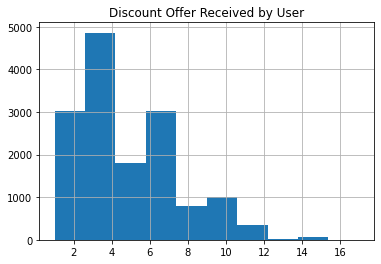

In [53]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count().hist()
plt.title('Discount Offer Received by User');

##### Detection
* Yet again, the highest ratio of completed offers is between 2 and 3 offers